# Assignment — Centrality measures

In [2]:
import numpy as np
from typing import Dict, List
import pandas as pd
from scipy.sparse.csgraph import reverse_cuthill_mckee
import networkx as nx
from networkx.algorithms import centrality
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

In this assignment, we will use Moscow Metro underground stations dataset taken from [Moscow Subway Optimal* Complete Route](https://medium.com/altsoph/moscow-subway-optimal-complete-route-ac98796dd652) research. Let us download and take a look at the data.

In [3]:
station_url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/stations_data.txt'
routes_url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/routes_data.txt'

In [4]:
stations = pd.read_csv(station_url)
routes = pd.read_csv(routes_url)

In [5]:
stations.head()

,id,line_name,station_name,station_type,delay_morning,delay_rush,delay_night,lat,lon
0,0,Sokolnicheskaya,Bulvar Rokossovskogo,deadend,120,90,360,55.814269,37.735117
1,1,Sokolnicheskaya,Cherkizovskaya,pass,120,90,360,55.802991,37.744825
2,2,Sokolnicheskaya,Preobrazhenskaya ploschad,pass,120,90,360,55.796172,37.715022
3,3,Sokolnicheskaya,Sokolniki,pass,120,90,360,55.789200,37.679706
4,4,Sokolnicheskaya,Krasnoselskaya,pass,120,90,360,55.779853,37.666077


In [6]:
routes.head()

,id_from,id_to,route_type,delay
0,0,1,drive,120
1,1,0,drive,120
2,1,2,drive,240
3,2,1,drive,240
4,2,3,drive,180


### Task 1. Metro graph (1 points)

Before we start analyzing centrality, let us build a graph of stations.

Write a function `metro_graph` that takes datasets `stations` and `routes` and returns a graph with all stations and routes of any type. Labels of nodes are in column `stations.id`. Nodes in `G.nodes` viewer should be in ascending order. All nodes should have attributes `station_name` and `line_name`.

In [7]:
def metro_graph(stations: pd.DataFrame, routes: pd.DataFrame) -> nx.Graph:
    """
    Build a graph with metro stations and routes
    
    :param stations: dataframe with undeground stations (nodes) description, column id is used for node id in the nx.Graph
    :param routes: edgelist for undeground graph. id_from is source and id_to is target nodes.
    :return: graph of Moscow undeground
    """
    G= nx.Graph()
    for index , srow in stations.iterrows():
      #G.add_node(row['id'])
      #G.add_node(srow['id'], {'station_name':srow['station_name'], 'line_name':srow['line_name']})
      G.add_node(srow['id'], station_name=srow['station_name'], line_name= srow['line_name'])
    for index , rrow in routes.iterrows():
      G.add_edge(rrow['id_from'],rrow['id_to'])
    return G
    # YOUR CODE HERE
    #raise NotImplementedError()

In [8]:
'''Check ordering of nodes, number of nodes, names of stations and lines'''
G = metro_graph(stations, routes)
assert (np.array(list(G.nodes)) == np.arange(194)).sum() == 194
assert G.number_of_edges() == 228
assert G.nodes[100]['station_name'] == 'Shabolovskaya'
assert G.nodes[100]['line_name'] == 'Kaluzhsko-Rizhskaya'

Let us draw the graph with default spring layout.

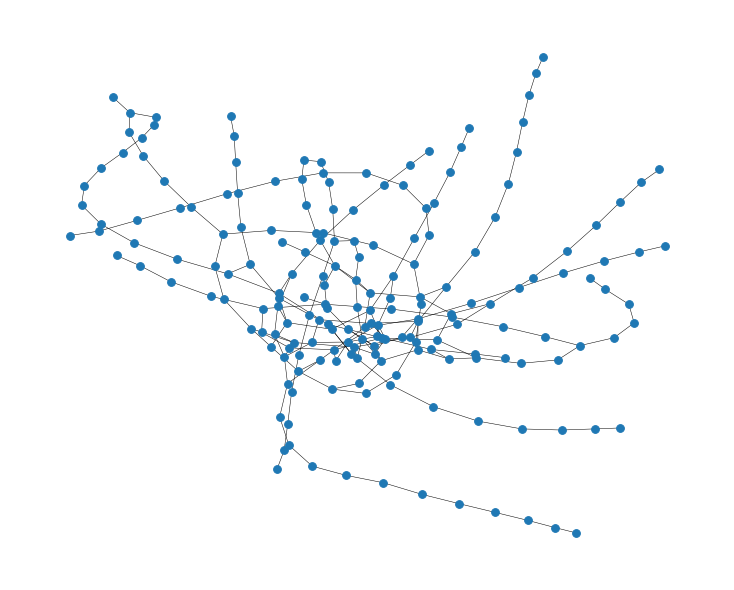

In [9]:
plt.figure(figsize=(10, 8))
nx.draw(G, 
        width=0.5,
        node_size=60)
plt.show()

So far it does not look like a metro map. Let us specify a distance based layout using information from the dataset `stations`.

Write a function `metro_layout` that takes the dataset `stations` and returns a dictionary with nodes as keys and positions as values:
```
{node_id: [longitude, latitude]}
```

In [10]:
def metro_layout(stations: pd.DataFrame) -> Dict[int, List[float]]:
    """
    Build a distance based layout of the metro graph
    
    :param stations: dataframe with undeground stations (nodes) description, column id is used for node id in the nx.Graph.
        lat and lon is geo coordinates of station.
    :return: geo layout of Moscow undeground
    """
    layout = {}
    for index , row in stations.iterrows():
      tmp_list =[]
      tmp_list.append(row['lon'])
      tmp_list.append(row['lat'])
      layout[row['id']] = tmp_list
    return layout
    # YOUR CODE HERE
    #raise NotImplementedError()

In [11]:
'''Check a type and positions of some random nodes'''
pos = metro_layout(stations)
assert type(pos) == dict
assert len(pos) == 194
assert pos[100] == [37.6078018, 55.71882329]
assert pos[172] == [37.72840065, 55.69297728]

Let us draw the graph with the distance based layout.

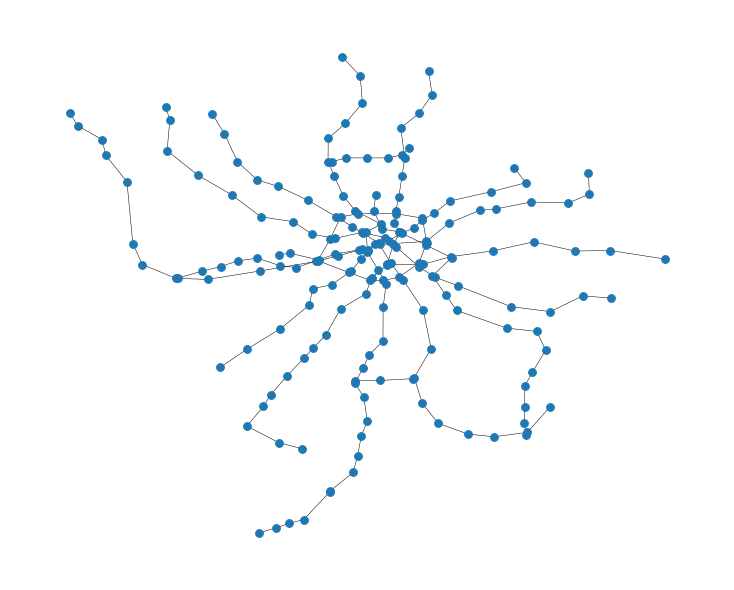

In [12]:
plt.figure(figsize=(10, 8))
nx.draw(G, 
        pos,
        width=0.5,
        node_size=60)
plt.show()

The final preprocessing step, let us colorize stations by their lines.

Write a function `station_color` that takes a graph `G` and returns a dictionary with nodes as keys and color as values. Colors are given in the `line_color` dictionary.

In [13]:
line_color = {
    'Sokolnicheskaya': 'tab:red',
    'Zamoskvoretskaya': 'tab:green',
    'Arbatsko-Pokrovskaya': 'tab:blue',
    'Filevskaya': 'deepskyblue',
    'Koltsevaya': 'tab:brown',
    'Kaluzhsko-Rizhskaya': 'tab:orange',
    'Tagansko-Krasnopresnenskaya': 'tab:purple', 
    'Kalininskaya': 'gold',
    'Serpuhovsko-Timiryazevskaya': 'gray', 
    'Lyublinsko-Dmitrovskaya': 'yellowgreen',
    'Kahovskaya': 'paleturquoise', 
    'Butovskaya': 'lightblue', 
    'Monorels': 'royalblue'
}

In [14]:
def station_color(G: nx.Graph, line_color: Dict[str, str] = line_color) -> Dict[int, str]:
    """
    Defines color of stations
    
    :param G: graph of Moscow undeground
    :param line_color: mapping of undeground lines to colors
    :return: mapping of node ids to its colors 
    """
    color_dic = {}
    for node in G.nodes:
      color_dic[node] = line_color[G.nodes[node]['line_name']]
      #node.node_color = line_color[node['line_name']]
    return color_dic
    # YOUR CODE HERE
    #raise NotImplementedError()

In [15]:
'''Check a type and colors of some random nodes'''
nx.set_node_attributes(G, station_color(G), 'color')
assert type(station_color(G)) == dict
assert len(station_color(G)) == 194
assert station_color(G)[9] == 'tab:red'
assert station_color(G)[193] == 'royalblue'
assert station_color(G)[119] == 'tab:purple'

Let us draw the graph with the distance based layout and stations colors.

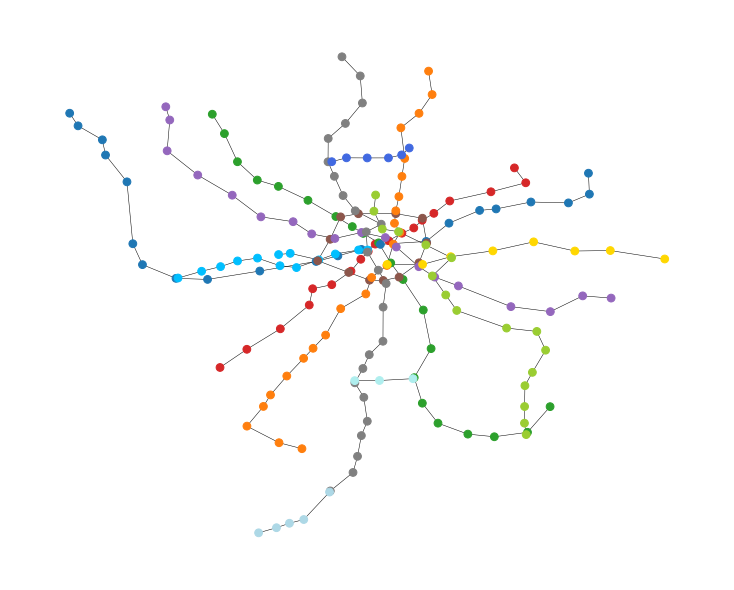

In [16]:
plt.figure(figsize=(10, 8))
nx.draw(
    G, 
    pos,
    width=0.5,
    node_color=list(nx.get_node_attributes(G, 'color').values()),
    node_size=60,
)
plt.show()

### Task 2. Degree, closeness, betweenness centralities (1 points)

Let us look at centrality measures of the metro stations graph. First, use networkx to calculate degree, closeness, betweenness centralities.

Write a function `centralities` that takes a graph `G` and returns a dictionary with keys `degree`, `closeness`, `betweenness`. The values are np.arrays with values of each centrality.

In [17]:
def centralities(G: nx.Graph) -> Dict[str, np.array]:
    """
    Calculate degree, closeness, betweenness centralities of the graph
    
    :param G: Moscow undeground graph
    :return: mapping of centrality names (degree, closeness, betweenness) to np.array of its values
    """
    
    degree_dic = centrality.degree_centrality(G)
    values = degree_dic.values()
    values_list = list(values)
    degree_array = np.asarray(values_list)
    #centralities['degree'] = values_list
    closeness_dic = centrality.closeness_centrality(G)
    values = closeness_dic.values()
    values_list = list(values)
    closeness_array = np.asarray(values_list)
    #centralities['closeness'] = np.asarray(values_list)
    betweenness_dic = centrality.betweenness_centrality(G)
    values = betweenness_dic.values()
    values_list = list(values)
    betweenness_array = np.asarray(values_list)
    #centralities['betweenness'] = np.asarray(values_list)
    centralities_dic = {'degree': degree_array , 'closeness':closeness_array , 'betweenness':betweenness_array}
    return centralities_dic
    # YOUR CODE HERE
    #raise NotImplementedError()

In [18]:
'''Check some random values of centralities'''
c = centralities(G)
assert c['degree'].shape[0] == 194
assert c['degree'][193] == 0.0051813471502590676
assert c['closeness'][94] == 0.12107904642409034
assert c['betweenness'][49] == 0.0991400402993669

Next, let us create a table with top 10 nodes for each centrality.

Write a function `top10_centralities` that takes a graph `G` and returns a dictionary with keys `degree`, `closeness`, `betweenness`. The values are pd.DataFrames with columns:
* `station` — station name
* `line` — line name
* `centrality` — value of a centrality

Each dataframe contains 10 rows with highest centrality values.

In [ ]:
#def get_top_10_from_array (a : np.array) -> 

In [19]:
def top10_centralities(G: nx.Graph) -> Dict[str, pd.DataFrame]:
    """
    Create table of top 10 nodes by degree, closeness, betweenness centralities
    
    :param G: graph of Moscow undeground
    :return: mapping of station name to the dataframe with columns (station, line, centrality)
    """
    df_degree = pd.DataFrame(columns=['station', 'line', 'centrality'])
    df_closeness = pd.DataFrame(columns=['station', 'line', 'centrality'])
    df_betweenness = pd.DataFrame(columns=['station', 'line', 'centrality'])

    degree_dic = centrality.degree_centrality(G)
    sorted_degree_dic = {k: v for k, v in sorted(degree_dic.items(), key=lambda item: item[1],reverse=True)}
    #degree_10 = sorted_degree_dic[:10]
    i=1
    for k , v in sorted_degree_dic.items():
      df_degree = df_degree.append({'station': G.nodes[k]['station_name'], 'line': G.nodes[k]['line_name'], 'centrality': v}, ignore_index=True)
      i= i+1
      if i>10:
        break

    c_dic = centrality.closeness_centrality(G)
    sorted_c_dic = {k: v for k, v in sorted(c_dic.items(), key=lambda item: item[1],reverse=True)}
    #c_10 = sorted_c_dic[:10]
    i=1
    for k , v in sorted_c_dic.items():
      df_closeness = df_closeness.append({'station': G.nodes[k]['station_name'], 'line': G.nodes[k]['line_name'], 'centrality': v}, ignore_index=True)
      i= i+1
      if i>10:
        break

    b_dic = centrality.betweenness_centrality(G)
    sorted_b_dic = {k: v for k, v in sorted(b_dic.items(), key=lambda item: item[1],reverse=True)}
    #b_10 = sorted_b_dic[:10]
    i=1
    for k , v in sorted_b_dic.items():
      df_betweenness = df_betweenness.append({'station': G.nodes[k]['station_name'], 'line': G.nodes[k]['line_name'], 'centrality': v}, ignore_index=True)
      i= i+1
      if i>10:
        break
    
    top10_cent = {}
    top10_cent['degree'] = df_degree
    top10_cent['closeness'] = df_closeness
    top10_cent['betweenness'] = df_betweenness

    return top10_cent
    

In [20]:
'''Check that some random nodes are in the top 10 tables'''
top_dfs = top10_centralities(G)
assert 'Biblioteka imeni Lenina' in top_dfs['degree']['station'].to_list()
assert 'Serpuhovskaya' in top_dfs['betweenness']['station'].to_list()
assert 'Teatralnaya' in top_dfs['closeness']['station'].to_list()
assert 'Arbatsko-Pokrovskaya' in top_dfs['closeness']['line'].to_list()

Following code makes a visualization: for each centrality it prints a top 10 table and graph, where the node size and color correspond to the centrality value.

Degree centrality


,station,line,centrality
0,Biblioteka imeni Lenina,Sokolnicheskaya,0.025907
1,Arbatskaya,Arbatsko-Pokrovskaya,0.025907
2,Kievskaya,Filevskaya,0.025907
3,Chistye prudy,Sokolnicheskaya,0.020725
4,Tverskaya,Zamoskvoretskaya,0.020725
5,Teatralnaya,Zamoskvoretskaya,0.020725
6,Novokuznetskaya,Zamoskvoretskaya,0.020725
7,Kurskaya,Arbatsko-Pokrovskaya,0.020725
8,Kievskaya,Arbatsko-Pokrovskaya,0.020725
9,Taganskaya,Koltsevaya,0.020725


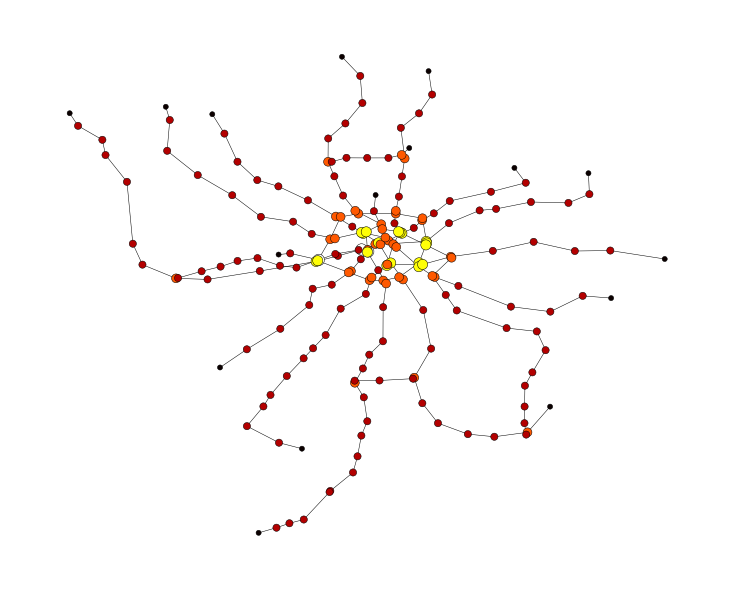

Closeness centrality


,station,line,centrality
0,Teatralnaya,Zamoskvoretskaya,0.141288
1,Ploschad Revolyutsii,Arbatsko-Pokrovskaya,0.141185
2,Novokuznetskaya,Zamoskvoretskaya,0.139350
3,Taganskaya,Koltsevaya,0.138849
4,Kurskaya,Koltsevaya,0.138849
5,Arbatskaya,Arbatsko-Pokrovskaya,0.138451
6,Chehovskaya,Serpuhovsko-Timiryazevskaya,0.137956
7,Paveletskaya,Koltsevaya,0.137857
8,Dobryninskaya,Koltsevaya,0.137464
9,Tretyakovskaya,Kaluzhsko-Rizhskaya,0.137269


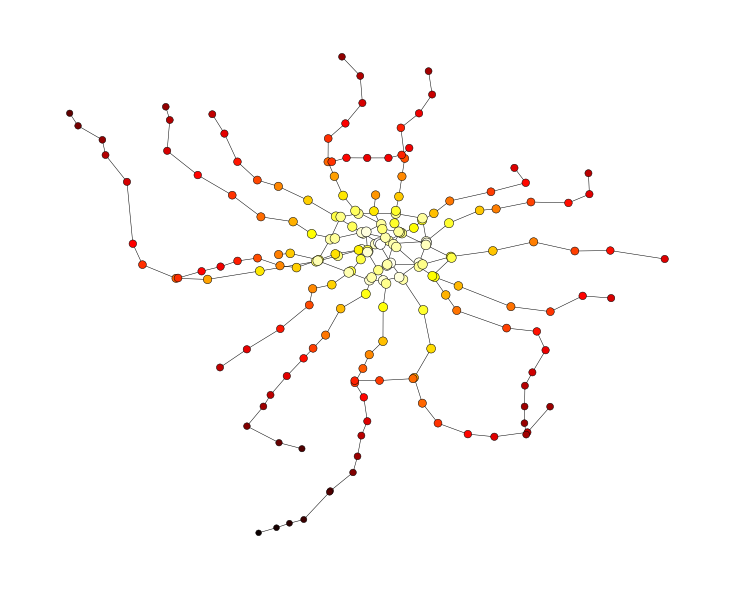

Betweenness centrality


,station,line,centrality
0,Kievskaya,Koltsevaya,0.172276
1,Serpuhovskaya,Serpuhovsko-Timiryazevskaya,0.144095
2,Kievskaya,Arbatsko-Pokrovskaya,0.133394
3,Tulskaya,Serpuhovsko-Timiryazevskaya,0.130192
4,Park kultury,Koltsevaya,0.130139
5,Dobryninskaya,Koltsevaya,0.129763
6,Oktyabrskaya,Koltsevaya,0.124274
7,Oktyabrskaya,Kaluzhsko-Rizhskaya,0.122584
8,Nagatinskaya,Serpuhovsko-Timiryazevskaya,0.122204
9,Krasnopresnenskaya,Koltsevaya,0.122121


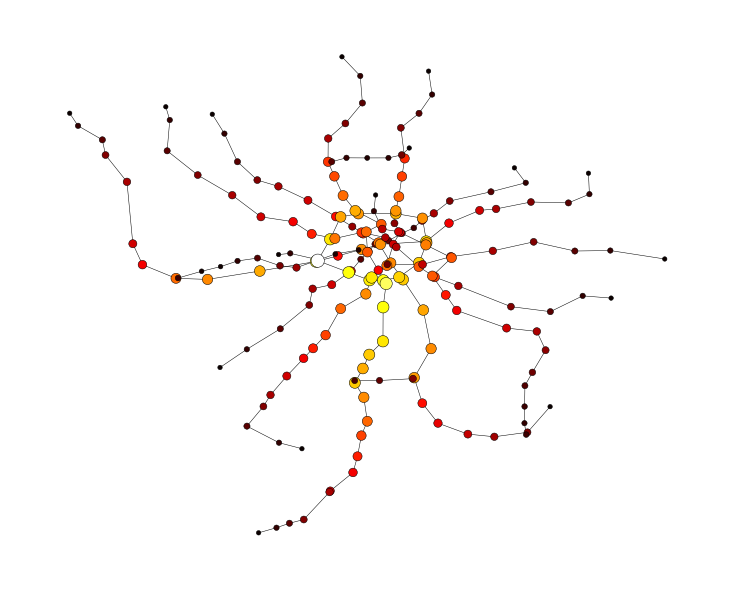

In [21]:
cases = [['degree', 5000, 0, 'Degree centrality'], 
         ['closeness', 700, 0, 'Closeness centrality'], 
         ['betweenness', 900, 20, 'Betweenness centrality']]
for c_key, scale, bias, title in cases:
    print(title)
    display(top_dfs[c_key])
    plt.figure(figsize=(10, 8))
    nx.draw(G, 
            pos,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            cmap=plt.cm.hot,
            node_size=c[c_key]*scale + bias,
            node_color=c[c_key])
    plt.show()

### Task 3. Center of a graph (1 points)

In the next section we will slightly modify the initial graph — truncate all stations that located outside of Sadovoye ring.
Sadovoye ring is the region that includes all stations on the Koltsevaya line, all stations of radial lines that intersect Koltsevaya line and all stations that contains inside the circle.

Write a function `metro_graph_center` that takes a metro graph `G` and returns a subgraph with stations inside Sadovoye ring.

_Hint: use centrality_

In [25]:
def metro_graph_center(G: nx.Graph) -> nx.Graph:
    """
    Build a subgraph with stations inside the Sadovoye ring
    
    :param G: graph of Moscow undeground
    :return: subgraph of Moscow undeground stations that is located inside Sadovoye ring.
    """
    #adding all nodes
    central_nodes = []
    for node in G.nodes():
      if G.nodes[node]['line_name'] =='Koltsevaya':
        central_nodes.append(node)
    
    closeness_dic = centrality.closeness_centrality(G)
    sorted_c_dic = {k: v for k, v in sorted(closeness_dic.items(), key=lambda item: item[1],reverse=True)}
    i=1
    n = len(central_nodes)
    for k , v in sorted_c_dic.items():
      if G.nodes[k]['line_name'] !='Koltsevaya':
        central_nodes.append(k)
        i = i+1
        if i>57-n:
          break
    # YOUR CODE HERE
    #raise NotImplementedError()
    return G.subgraph(central_nodes).copy()

In [26]:
'''Check the number of nodes and edges and some random stations'''
subG = metro_graph_center(G)
assert len(subG.nodes) == 57
assert len(subG.edges) == 85
assert 149 in list(subG.nodes)
assert 82 in list(subG.nodes)
assert 137 in list(subG.nodes)

AssertionError: ignored

In [27]:
%debug


> <ipython-input-26-c552b5257d3d>(4)<module>()
      2 subG = metro_graph_center(G)
      3 assert len(subG.nodes) == 57
----> 4 assert len(subG.edges) == 85
      5 assert 149 in list(subG.nodes)
      6 assert 82 in list(subG.nodes)

ipdb> len(G.edges)
228
ipdb> len(subG.edges)
84
ipdb> subG.nodes
NodeView((7, 8, 9, 10, 137, 136, 12, 11, 135, 146, 147, 148, 149, 150, 151, 25, 26, 27, 28, 29, 30, 31, 165, 166, 167, 168, 46, 47, 48, 49, 50, 51, 69, 72, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 94, 95, 96, 97, 98, 99, 119, 120, 121, 122, 123))
ipdb> quite
*** NameError: name 'quite' is not defined
ipdb> quit



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 357, in set_quit
    sys.settrace(None)



Let us draw the center of the metro graph with station names and colors.

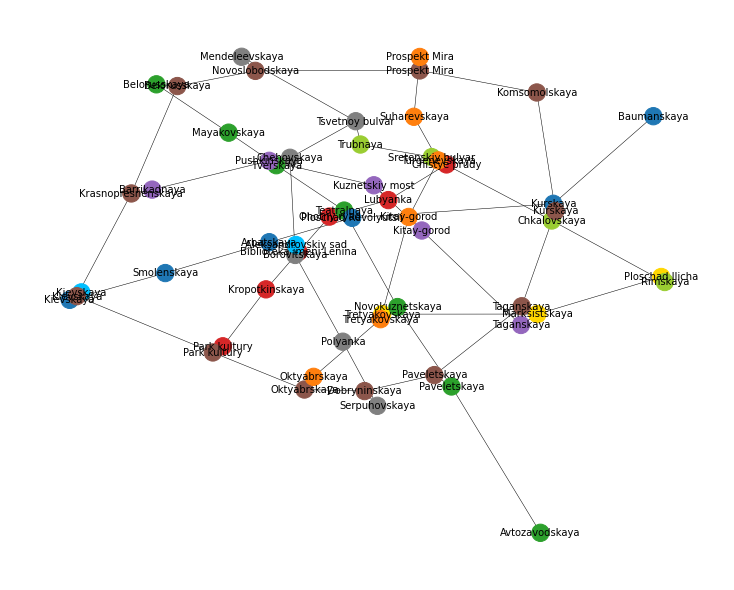

In [28]:
plt.figure(figsize=(10, 8))
nx.draw(subG, 
        pos,
        width=0.5,
        node_color=list(nx.get_node_attributes(subG, 'color').values()),
        labels=nx.get_node_attributes(subG, 'station_name'),
        font_size=10)
plt.show()

### Task 4. Centrality centralization (2 points)

The center of the metro graph looks a bit like a circular graph. We can see that a circular graph has the lowest centralization since

$$\text{Centralization} = \frac{\sum_i^N[C_x(p_*) - C_x(p_i)]}{\max\sum_i^N[C_x(p_*) - C_x(p_i)]}$$

where 
* $C_x$ — some centrality measure
* $p_i$ — $i$-th node
* $p_*$ — node with the largest centrality value
* $\max$ — maximum over all possible graphs with the same number of nodes (a star graph for degree, betweenness, closeness centralities).

Let us check how centralization changes during transformation our truncated graph into a pure circular graph.

Write a function `centralization_seq` that takes the truncated graph `G` and deletes stations except of Koltsevaya line one-by-one in ascending order on node ids (i.e. result of `sorted` function). In each step after removal, the centralization is calculated. The function returns a tuple:
* a dictionary where keys are `degree`, `closeness`, `betweenness` and values are np.arrays with centralization values
* a list of ordered removed nodes

In [ ]:
def centralization_seq(G: nx.Graph) -> (Dict[str, np.array], List[str]):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
'''Check the output shape and some random centralization values'''
cent, order = centralization_seq(subG)
assert len(order) == 45
assert order[0] == 5
assert order[-1] == 167
assert cent['degree'].shape == (45,)
assert cent['closeness'].shape == (45,)
assert cent['betweenness'].shape == (45,)
assert cent['degree'][-1] == cent['betweenness'][-1] == cent['closeness'][-1]
assert cent['degree'][41].round(4) == 0.0824
assert cent['degree'][2].round(4) == 0.0406
assert cent['closeness'][11].round(4) == 0.0785
assert cent['closeness'][9].round(4) == 0.0814
assert cent['betweenness'][14].round(4) == 0.1178

Let us draw how the centralization changes when the graph tends to a circular graph.

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(cent['degree'], label='Degree')
plt.plot(cent['closeness'], label='Closeness')
plt.plot(cent['betweenness'], label='Betweenness')
plt.ylabel('Centralization')
plt.xlabel('Number of deleted nodes')
plt.axvline(16, linestyle='--', color='C4', alpha=0.5)
plt.axvline(30, linestyle='--', color='C4', alpha=0.5)
plt.axvline(37, linestyle='--', color='C4', alpha=0.5)
plt.axvline(41, linestyle='--', color='C4', alpha=0.5)
plt.legend()
plt.show()

We can see the significant peaks in betweenness centralization. Higher centralization means that centrality measures unevenly distributed over nodes. Betweenness centrality for specific node indicates how much shortest paths pass through this node. Peaks signalize that we break some shortests paths after node deletion, so new shortest paths should go through a little number of specific nodes. Let us visualize graph before and after deletion of a node under index `37` (Tsvetnoy bulvar), to understand this effect.

In [ ]:
plt.figure(figsize=(12, 6))
cases = [[36, [147, 77, 78, 79, 80]], [37, [77, 78, 79, 80]]]
station_names = nx.get_node_attributes(subG, 'station_name')
for i, (node_id, stations) in enumerate(cases):
    plt.subplot(1, 2, i+1)
    s = subG.copy()
    s.remove_nodes_from(order[:node_id + 1])
    betw = nx.betweenness_centrality(s)
    nx.draw(
        s,
        pos,
        width=0.5,
        node_color=list(nx.get_node_attributes(s, 'color').values()),
        node_size=[(j*60 + 5)**2 for i, j in betw.items()],
        labels={n:v for n, v in station_names.items() if n in stations})
    plt.title('Betweenness centralization: {:.2f}'.format(cent['betweenness'][node_id]))

Tsvetnoy bulvar is a node targeted for deletion on the next step. The node size is betweenness centrality. On the first graph we can see, that exists a cycle of gray and light green line, so all nodes on that lines can easily access each other via shortest path. However, after deletion of Tsvetnoy bulvar, the cycle is broken. So to connect stations between gray and light green lines, it is required to pass through line intersection with Koltsevaya and some stations on it. It raises the value of betwenness centrality for such nodes (e.g. Dobryninskaya, Paveletskaya, Taganskaya, Kurskaya), keeping the old values for the rest of graph. It leads to the increase of overall graph centralization for betwenness centrality.

### Task 5. PageRank algorithm (1 points)

Implement PageRank algorithm. A function `page_rank` takes a graph `G`, transition coefficient `alpha` and number of iterations `k`. The function returns np.array of PageRank scores.


In [22]:
'''Do not touch the cell'''
def page_rank(G, alpha, k):
    A = nx.to_numpy_array(G)
    P = transition_matrix(A)
    v = teleportation_vector(A)
    rank = np.ones(A.shape[0]) / A.shape[0]
    for _ in range(k):
        rank = update_rank(rank, P, v, alpha)
    return rank / rank.sum()

Write a function `transition_matrix` that takes a np.array with an adjacency matrix `A` and returns a np.array with a transition matrix where an entry $p_{ij}$ equals to probability of going to $j$ if we are in $i$.

In [23]:
def transition_matrix(A):
  rows = len(A)
  cols = len(A[0])
  r, c = (rows, cols)
  arr = np.zeros((r,c))
  sum_list =A.sum(axis =1)
  #D_array =  np.diag(sum_list)
  #D_inverse = np.linalg.inv(D_array)
  #return np.asarray (np.dot(D_inverse ,A))
  for i in range(r):
    for j in range (c):
      if sum_list[i] != 0:
        arr[i][j] = float (A[i][j]/sum_list[i])

  return np.asarray(arr)
    # YOUR CODE HERE
    #raise NotImplementedError()

In [24]:
A = [[0, 1, 1], # probability P(0→1) = P(0→2) = 1/2
     [0, 0, 1], # probability P(1→2) = 1
     [1, 0, 0]] # probability P(2→0) = 1
A = np.array(A)
tran_sum = transition_matrix(A).sum(axis=1)
assert tran_sum[0] == tran_sum[1] == tran_sum[2] == 1

Write a function `teleportation_vector` that takes a np.array with an adjacency matrix `A` and returns a np.array with a teleportation vector where $p_i$ is a probability to teleport to a node $i$ (by default it is a uniform distribution).

In [25]:
def teleportation_vector(A):
    n = len(A)
    arr = np.ones(n) *1/n
    return np.asarray(arr)
    # YOUR CODE HERE
    #raise NotImplementedError()

In [26]:
assert teleportation_vector(A).sum() == 1

Write a function `update_rank`. Check the function `page_rank` to understand parameters. An iterative process is defined as

$$\begin{matrix}
r &=& \text{transition} &+& \text{teleportation}\\
r &=& \alpha P^T r &+& (1 - \alpha)v
\end{matrix}
$$

where $P$ is a transition matrix, $v$ is a teleportation vector.

In [27]:
def update_rank(rank, P, v, alpha):
  tmp_arr = np.transpose(P)
  t_alpha = alpha * tmp_arr
  trans_arr = np.dot(t_alpha, rank)
  tele_arr = (1-alpha)* v
  return trans_arr +tele_arr
    # YOUR CODE HERE
    #raise NotImplementedError()

In [28]:
G = nx.path_graph(6, create_using=nx.DiGraph)
pr = page_rank(G, 0.9, 100)
assert np.all(pr[1:] - pr[:-1] > 0)

In [91]:
%debug

> <ipython-input-90-7edb7c61b7d7>(3)<module>()
      1 G = nx.path_graph(6, create_using=nx.DiGraph)
      2 pr = page_rank(G, 0.9, 100)
----> 3 assert np.all(pr[1:] - pr[:-1] > 0)

ipdb> pr
array([0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.91666667])
ipdb> quit


Let us draw the graph where node size depends on PageRank.

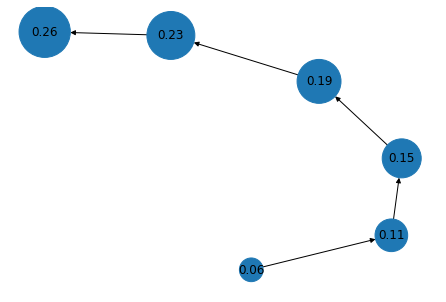

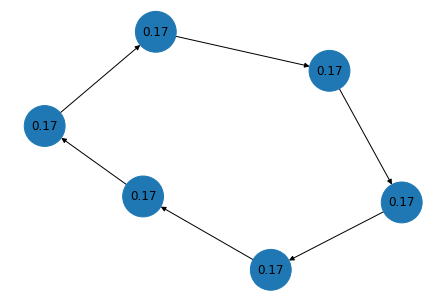

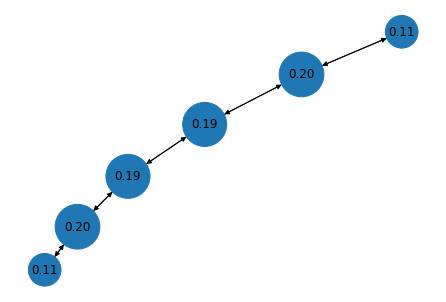

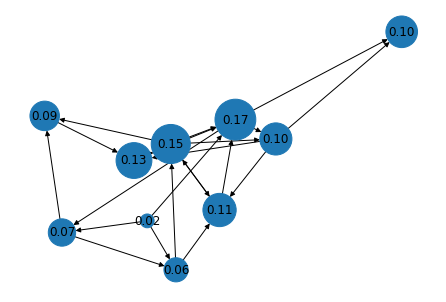

In [29]:
graphs = [
    nx.path_graph(6, create_using=nx.DiGraph),
    nx.cycle_graph(6, create_using=nx.DiGraph),
    nx.DiGraph(nx.path_graph(6)),
    nx.erdos_renyi_graph(10, 0.2, directed=True)
]
for G in graphs:
    pr = page_rank(G, 0.9, 100)
    nx.draw(
        G,
        with_labels=True,
        node_size=(pr * 1e4),
        labels={node: f'{rank:.2f}' for node, rank in enumerate(pr)}
    )
    plt.show()

### Task 6. Personalized PageRank (2 points)

Personalized PageRank uses a teleportation vector as personal preferences, so that an important node has high probability to jump into it. Personalized PageRank can be considered as a simple recommender system. Consider a dataset of links between some famous painters on Wikipedia. Common PageRank gives us following ranks.

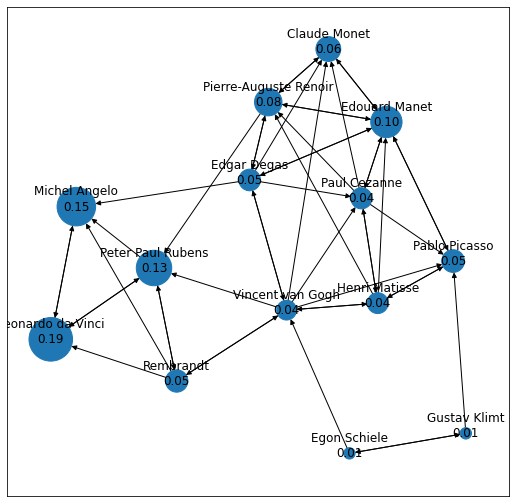

In [30]:
def plot_painters(G, pr):
    pos = nx.kamada_kawai_layout(G)
    plt.figure(figsize=(9, 9))
    nx.draw_networkx(
        G, 
        pos, 
        node_size=(pr * 1e4), 
        labels={node: f'{rank:.2f}' for node, rank in enumerate(pr)})
    nx.draw_networkx_labels(
        G, 
        pos={node: pos[node] + [0, 0.05] for node in pos}, 
        labels=nx.get_node_attributes(G, 'name')
    )

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/painters_graph.gml'
open('painters_graph.gml', 'wb').write(requests.get(url).content)
G = nx.read_gml('painters_graph.gml')
G = nx.convert_node_labels_to_integers(G)
pr = np.array([rank for node, rank in nx.pagerank(G, alpha=0.9).items()])
plot_painters(G, pr)
plt.show()

Now let us calculate personalized PageRank based on user's preferences. Construct a teleportation vector so that painters a user likes are proportional to ones and others are zeros.

Write a function `personalized_pr` that takes an argument of common PageRank and a list `pref` that contains names of painters that user likes. The function returns personalized PageRank.

In [31]:
def personalized_pr(G, alpha, pref, k):
    A = nx.to_numpy_array(G)
    P = transition_matrix(A)
    #v = teleportation_vector(A)
    n = len(A)
    tmp_pref = np.zeros(n)
    for node in G.nodes:
      if G.nodes[node]['name'] in pref:
        tmp_pref[node]= 1
    rank = np.ones(A.shape[0]) / A.shape[0]
    for _ in range(k):
      tmp_arr = np.transpose(P)
      t_alpha = alpha * tmp_arr
      trans_arr = np.dot(t_alpha, rank)
      tele_arr = (1-alpha)* tmp_pref
      rank = trans_arr +tele_arr
    return rank / rank.sum()
    # YOUR CODE HERE
    #raise NotImplementedError()

In [32]:
pref = ['Pablo Picasso', 'Edgar Degas']
pr1 = personalized_pr(G, alpha=0.9, pref=pref, k=100)
pref = ['Edgar Degas']
pr2 = personalized_pr(G, alpha=0.9, pref=pref, k=100)
assert np.isclose(pr1.sum(), 1) and np.isclose(pr2.sum(), 1)
assert pr1[0] > pr2[0]
assert pr1[7] < pr2[7]

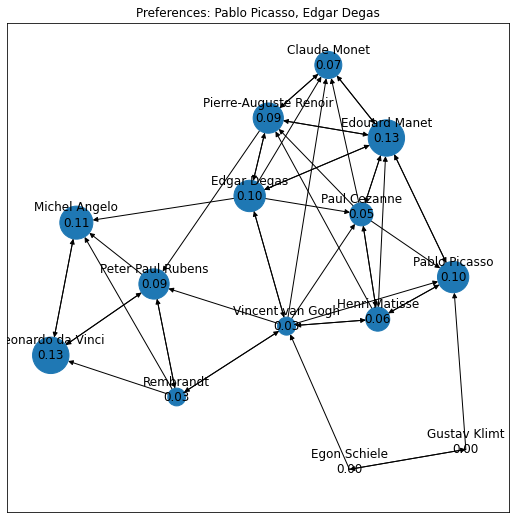

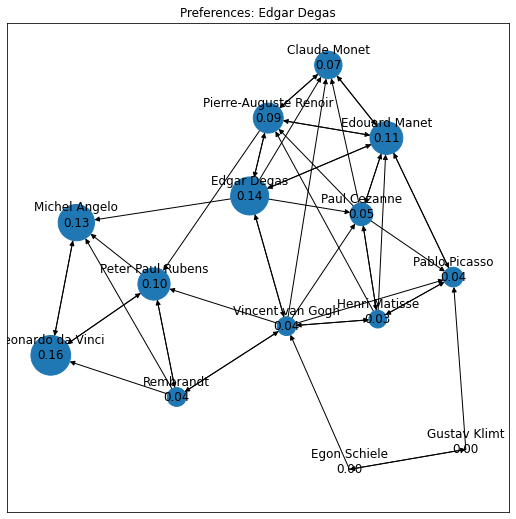

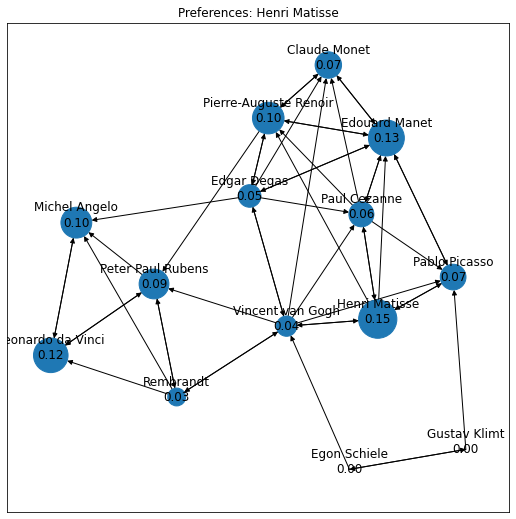

In [33]:
cases = [
    ['Pablo Picasso', 'Edgar Degas'], 
    ['Edgar Degas'], 
    ['Henri Matisse']
]
for pref in cases:
    pr = personalized_pr(G, alpha=0.9, pref=pref, k=100)
    plot_painters(G, pr)
    pref = ', '.join(pref)
    plt.title(f'Preferences: {pref}')

Low transionion coefficient forces to teleport into prefferential nodes and vice versa, so we can adjust the power of preferences changing transionion coefficient.

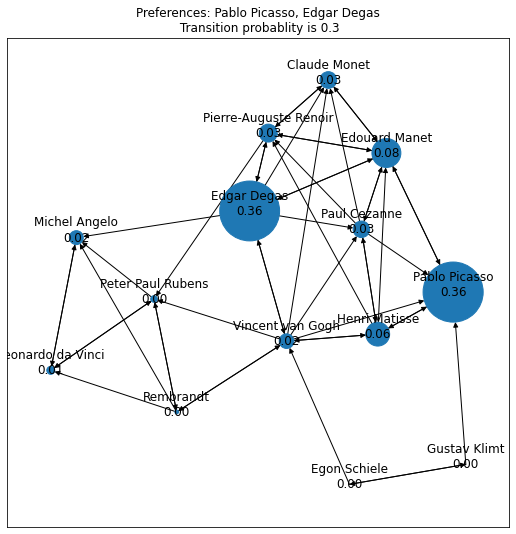

In [34]:
pref = ['Pablo Picasso', 'Edgar Degas']
alpha = 0.3
pr = personalized_pr(G, alpha=alpha, pref=pref, k=100)
plot_painters(G, pr)
pref = ', '.join(pref)
plt.title(f'Preferences: {pref}\n Transition probablity is {alpha}');

### Task 7. HITS visualization (2 points)

In this task we will try to find authorities and hubs in political blogs and visualize them. The data is provided from [Political blogosphere Feb. 2005](http://vlado.fmf.uni-lj.si/pub/networks/data/mix/mixed.htm) dataset.

The graph contains parallel edges, but HITS algorithm only works without parallel edges. The simplest way to drop parallel edges is to convert a directed multigraph (`nx.MultiDiGraph`) into a directed graph (`nx.DiGraph`).

Write a function `hits_polblogs` that takes a path to a gml file with data and returns a tuple with a graph and two dictionaries of the form
* `{node: value}`

The first dictionary is hub scores, the second one is authority scores. That is, a full output is `(G, hub, auth)`. Apply `nx.hits` to calculate hub and authority scores.

In [54]:
def hits_polblogs(filename):
  G = nx.read_gml(filename)
  #G = nx.convert_node_labels_to_integers(G)
  #H = nx.MultiDiGraph.to_directed(G)
  #H = G.to_directed()
  H = nx.DiGraph(G)
  #hub = {}
  #auth= {}
  h , a = nx.algorithms.link_analysis.hits_alg.hits(H)
  return H , h ,a
    # YOUR CODE HERE
    #raise NotImplementedError()

In [55]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/polblogs.gml'
open('polblogs.gml', 'wb').write(requests.get(url).content)
G, hub, auth = hits_polblogs('polblogs.gml')
assert type(G) == nx.DiGraph
assert len(hub.values()) == len(auth.values()) == 1490
assert round(max(hub.values()), 4) == 0.0069
assert round(max(auth.values()), 4) == 0.015

In [56]:
G.number_of_nodes()

1490

In [57]:
G.number_of_edges()

19025

There are many edges and nodes and it makes hard to draw the whole graph. Then, let us draw a scatter plot with hub and authority scores.

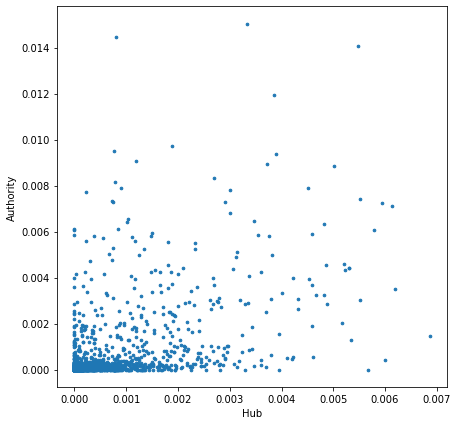

In [58]:
plt.figure(figsize=(7, 7))
plt.scatter(hub.values(), auth.values(), s=7)
plt.xlabel('Hub')
plt.ylabel('Authority')
plt.show()

Next, draw a graph with 14 nodes: top 7 authorities and top 7 hubs. Hubs will be on the left, authorities will be on the right.

Write a function `hits_visualization` that takes a graph `G`, hub, authority dictionaries, the number of top nodes and returns a dictionary with keys:
* `h_top` — np.array of top nodes by hub score
* `a_top` — np.array of top nodes by authority score
* `subG` — subgraph of `G` with top nodes only
* `h_vals` — np.array with hub scores (in initial graph) of top nodes that ordered by `subG.nodes` view 
* `a_vals` — the same for authority score
* `pos` — dictionary with keys are nodes and values are x-y positions of the form

`{node: [x, y]}` where 
* x equals to 0 if it is a hub and 1 if it is a authority
* y equals to an index of top array

That is, x could be 0 or 1 and y could be 0, 1, ..., 6.

In [61]:
def hits_visualization(G, hub, auth, top):
  output = {}
  #hn_top_arr = np.ones(top)
  #an_top_arr = np.ones(top)
  hn_top_arr = []
  an_top_arr = []
  hv_top_arr = np.ones(top*2)
  av_top_arr = np.ones(top*2)
  pos = {}
  node_list = []
  sorted_hub_dic = {k: v for k, v in sorted(hub.items(), key=lambda item: item[1],reverse=True)}
  sorted_auth_dic = {k: v for k, v in sorted(auth.items(), key=lambda item: item[1],reverse=True)}
  i=0
  for k , v in sorted_hub_dic.items():
    #hn_top_arr[i] = k
    hn_top_arr.append(k)
    #hv_top_arr[i] = v
    node_list.append(k)
    pos[k] = [0,i]
    #df_degree = df_degree.append({'station': G.nodes[k]['station_name'], 'line': G.nodes[k]['line_name'], 'centrality': v}, ignore_index=True)
    i= i+1
    if i>=top:
      break
  i=0
  for k , v in sorted_auth_dic.items():
    #an_top_arr[i] = k
    an_top_arr.append(k)
    #hv_top_arr[i] = v
    node_list.append(k)
    pos[k] = [1,i]
    #df_degree = df_degree.append({'station': G.nodes[k]['station_name'], 'line': G.nodes[k]['line_name'], 'centrality': v}, ignore_index=True)
    i= i+1
    if i>=top:
      break
  sub_G = G.subgraph(node_list).copy()
  i = 0 
  for node in sub_G.nodes:
    hv_top_arr[i] = hub[node]
    av_top_arr[i] = auth[node]
    i = i+1
  output = {}
  output['h_top'] = np.asarray(hn_top_arr)
  output['a_top'] = np.asarray(an_top_arr)
  output['subG'] = sub_G
  output['h_vals'] = hv_top_arr
  output['a_vals'] = av_top_arr
  output['pos'] = pos
  return output
    # YOUR CODE HERE
    #raise NotImplementedError()

In [62]:
vi = hits_visualization(G, hub, auth, 7)
h_top, a_top = vi['h_top'], vi['a_top']
h_vals, a_vals = vi['h_vals'], vi['a_vals']
subG, pos = vi['subG'], vi['pos']
assert h_top.shape[0] == a_top.shape[0] == int(len(subG) / 2) == 7
assert 'politicalstrategy.org' == h_top[0]
assert 'talkingpointsmemo.com' in a_top
assert h_vals.shape == a_vals.shape == (14,)
assert h_vals.max() < 0.0069
assert 0 <= a_vals.min()
assert pos['atrios.blogspot.com'] == [1, 2]
assert pos['juancole.com'] == [1, 5]

Networkx allows to draw nodes, edges, labels separately. In this case, we need to fix a layout and then draw a graph by layers. Let us draw a graph via `nx.draw_networkx`, then draw right labels and then draw left labels via `nx.draw_networkx_labels`. Also we will crop labels with more than 15 symbols to fit on the screen.

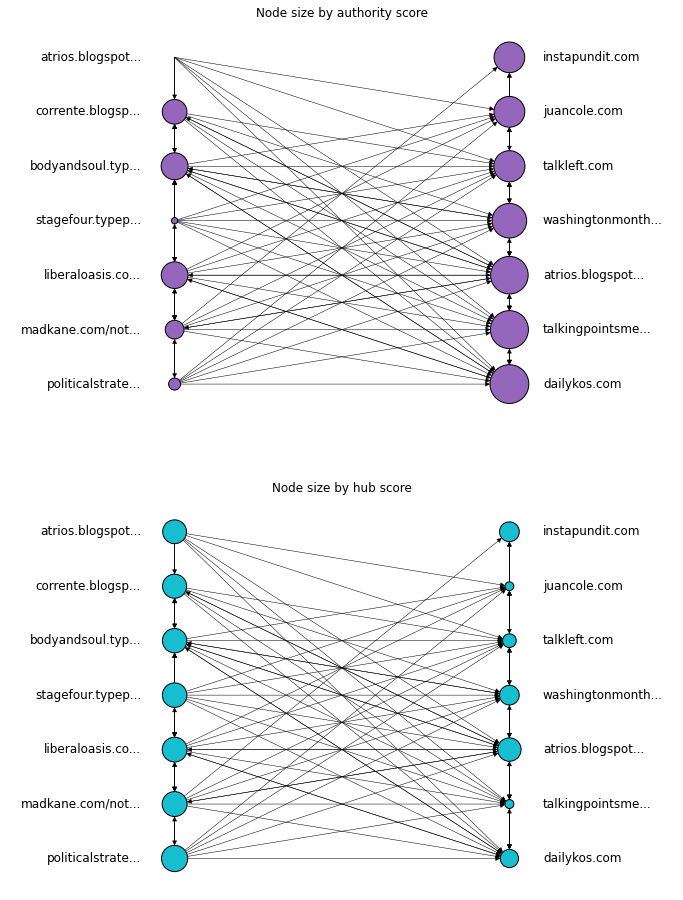

In [63]:
plt.figure(figsize=(12, 8*2))

h_labels = {i:i[:15] if len(i)<=15 else i[:15] + '...' for i in h_top}
a_labels = {i:i[:15] if len(i)<=15 else i[:15] + '...' for i in a_top}
a_pos = {node:(pos[node][0] + 0.1, pos[node][1]) for node in pos}
h_pos = {node:(pos[node][0] - 0.1, pos[node][1]) for node in pos}

cases = [[1, 'tab:purple', a_vals, 'Node size by authority score'], 
         [2, 'tab:cyan', h_vals, 'Node size by hub score']]
for i, color, vals, t in cases:
    plt.subplot(2, 1, i)
    plt.gca().axis('off')
    nx.draw_networkx(
        subG,
        pos,
        width=0.5,
        with_labels=False,
        edgecolors='black',
        node_size=vals*1e5,
        node_color=color
    )
    nx.draw_networkx_labels(
        subG,
        pos=a_pos,
        labels=a_labels,
        horizontalalignment='left'
    )
    nx.draw_networkx_labels(
        subG,
        pos=h_pos,
        labels=h_labels,
        horizontalalignment='right'
    )

    plt.xlim(-0.5, 1.5)
    plt.title(t)